## Setup the Env


In [1]:
import os
import sys

import sagemaker
from sagemaker import get_execution_role

# Add the parent directory to the sys.path
sys.path.insert(0, os.path.abspath(".."))

# Define IAM role
role = get_execution_role()
role

# Establish S3 bucket connection
import boto3

s3 = boto3.client("s3")
bucket = "capstone-bucket-4-friends"

# Take a look at current dir
print(os.getcwd())

from file_utilities import s3_download

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
/home/sagemaker-user/capstone-2024-summer/src/shuo


## Import Package

In [10]:
!pip install seaborn
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import joblib
import time
import pyarrow.parquet as pq
import pyarrow as pa

warnings.filterwarnings("ignore")

## Load Data

In [3]:
# reload_path = s3_download("CRSP/crsp_2018-2023_S&P500_train_dataset.pkl")
# reload_path = s3_download("CRSP/crsp_2018-2023_S&P500_val_dataset.pkl")
# reload_path = s3_download("CRSP/one_hot_encoder.pkl")

In [4]:
class FinancialDataset(Dataset):
    def __init__(self, data, window_size=128, one_hot_encoder=None):
        self.data = data
        self.window_size = window_size
        self.input_columns = [
            "log_return",
            "sector_weighted_avg_log_return",
            "sector_simple_avg_log_return",
            "weighted_avg_log_return",
            "simple_avg_log_return",
        ]
        self.target_columns = [
            "log_return",
            "abs_log_return",
            "log_return_7",
            "abs_log_return_7",
            "log_return_14",
            "abs_log_return_14",
            "log_return_28",
            "abs_log_return_28",
            "volatility_7",
            "volatility_14",
            "volatility_28",
        ]

        self.data[self.input_columns] = self.data[self.input_columns].apply(pd.to_numeric, errors="coerce")
        self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors="coerce")
        self.data = self.data.dropna()

        self.one_hot_encoder = one_hot_encoder
        if self.one_hot_encoder is None:
            self.one_hot_encoder = OneHotEncoder(sparse_output=False)
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.fit_transform(self.data[["permno_id"]])
        else:
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.transform(self.data[["permno_id"]])

        # Assign positional encoding
        self.data['positional_encoding'] = self.data.groupby("permno_id").cumcount()
        
        # Group by permno_id
        self.groups = self.data.groupby("permno_id")
        self.sequences = []

        for name, group in self.groups:
            permno_id_one_hot = self.one_hot_encoder.transform(group[["permno_id"]])
            if len(group) > self.window_size:
                for i in range(len(group) - self.window_size):
                    X = group[self.input_columns].iloc[i : i + self.window_size].values
                    # print(X)
                    # permno_id_one_hot_repeated = np.tile(permno_id_one_hot[i], (self.window_size, 1))
                    # print(permno_id_one_hot_repeated.shape)
                    # positional_encoding = np.arange(self.window_size).reshape(-1, 1)
                    # print(positional_encoding.shape)
                    X = np.concatenate([X, permno_id_one_hot[i:i + self.window_size]], axis=1)  # Concatenate one-hot encoded permno_id
                    X = np.concatenate([X, group['positional_encoding'].iloc[i: i + self.window_size].values.reshape(-1, 1)], axis=1)
                    # X = np.concatenate([X, permno_id_one_hot_repeated, positional_encoding], axis=1)
                    # print(X.shape)
                    y = group[self.target_columns].iloc[i + self.window_size].values
                    self.sequences.append((X, y, name))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y, permno_id = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            "permno_id": permno_id,
        }

In [5]:
%%time
# Load datasets
train_dataset = joblib.load('/home/sagemaker-user/capstone-2024-summer/data/crsp_2018-2023_S&P500_train_dataset.pkl')
val_dataset = joblib.load('/home/sagemaker-user/capstone-2024-summer/data/crsp_2018-2023_S&P500_val_dataset.pkl')

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

CPU times: user 3min 31s, sys: 5min 5s, total: 8min 37s
Wall time: 1h 3min 57s


In [7]:
# Load the OneHotEncoder
one_hot_encoder = joblib.load('/home/sagemaker-user/capstone-2024-summer/data/one_hot_encoder.pkl')

## Build and Train Model

In [8]:
%%time
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(0, 1)  # Transformer expects input of shape (seq_len, batch_size, embed_dim))
        x = self.transformer(x)
        embedding = x[-1, :, :]  # Get the last output token
        x = self.hidden_layers(embedding)
        x = self.fc(x)
        return x, embedding

CPU times: user 9 µs, sys: 12 µs, total: 21 µs
Wall time: 23.1 µs


Starting Training...
Epoch 1/5, Training Loss: 0.08991603399898838, Validation Loss: 0.08288494947360081
Epoch 2/5, Training Loss: 0.08809037651011052, Validation Loss: 0.08511038367212022
Epoch 3/5, Training Loss: 0.08806479840869516, Validation Loss: 0.08210426250307941
Epoch 4/5, Training Loss: 0.08801856906747106, Validation Loss: 0.08376320262065753
Epoch 5/5, Training Loss: 0.0879671503753776, Validation Loss: 0.08177414072081954
Training Complete


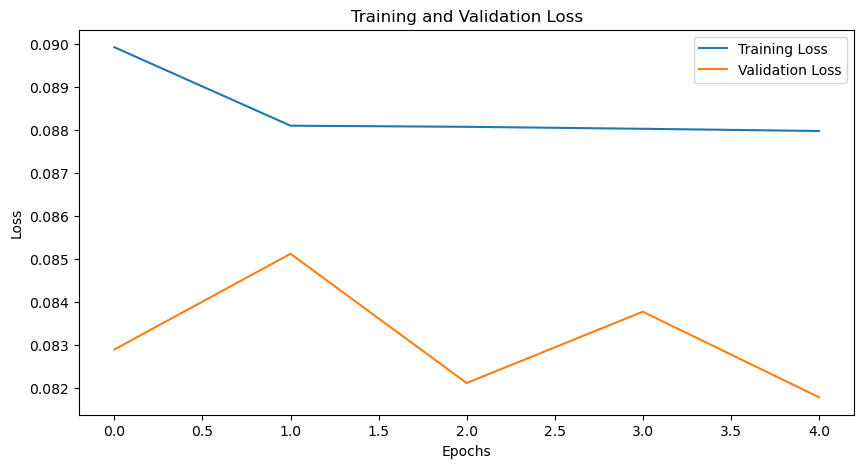

CPU times: user 8d 5h 2min 16s, sys: 1d 11h 49min 7s, total: 9d 16h 51min 23s
Wall time: 4h 51min 4s


In [11]:
%%time
# Initialize Model
# Update input_dim to include one-hot encoded permno_id length
input_dim = len(train_dataset.input_columns) + len(one_hot_encoder.categories_[0]) + 1
model = TransformerModel(
    input_dim=input_dim,
    embed_dim=256,
    n_heads=16,
    ff_dim=1024,
    n_layers=6,
    output_dim=len(train_dataset.target_columns),
    dropout=0.25,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
criterion = nn.L1Loss()

train_losses = []
val_losses = []

num_epochs = 5
patience = 3
best_val_loss = float("inf")
patience_counter = 0

print("Starting Training...")
for epoch in range(num_epochs):
    start_time = time.time()  # Record the start time
    model.train()
    running_loss = 0.0
    for batch in train_dataloader:
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_dataloader))
    
    epoch_time = time.time() - start_time  # Calculate the elapsed time
    print(f"Epoch {epoch+1}/{num_epochs} took {epoch_time:.2f} seconds")
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()


## Stock Embedding

In [12]:
%%time
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

CPU times: user 11h 4min 46s, sys: 6h 8min 33s, total: 17h 13min 19s
Wall time: 21min 32s


In [13]:
%%time
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

CPU times: user 9.5 s, sys: 138 ms, total: 9.63 s
Wall time: 505 ms


In [14]:
list(stock_embeddings.items())[:2]

[('10104',
  array([-1.28076851e-01, -1.11214750e-01, -1.71452060e-01,  3.27454433e-02,
         -1.80875266e+00, -2.47436427e-02,  1.03919476e-01,  5.66984005e-02,
         -2.29324568e-02, -4.48262095e-01,  4.18114996e+00,  5.57100363e-02,
          6.10681325e-02, -1.02311648e-01, -5.79268076e-02, -7.60177493e-01,
         -6.29735813e-02, -6.53207451e-02,  1.97310403e-01, -1.66576803e-01,
          3.90195241e-03, -4.75511365e-02, -3.03839231e+00, -4.87547070e-02,
         -3.91833931e-02, -3.34014967e-02, -6.30134121e-02,  2.99506374e-02,
         -1.94048826e-02, -8.57309997e-02, -4.21287119e-01,  3.19744349e-02,
         -1.65162206e-01, -6.53480366e-02,  2.02827435e-02, -5.22994474e-02,
          2.06882089e-01, -7.49328673e-01, -5.47714159e-02,  7.56143183e-02,
         -2.32606083e-02,  1.52298257e-01, -5.32961711e-02,  1.87605619e-02,
          1.21032692e-01,  2.63216794e-01, -4.73346800e-01, -8.27256665e-02,
          5.73349409e-02,  7.27213919e-03,  3.06049921e-02,  2.70

## Cosine Similarity Matrix

In [16]:
%%time
# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

CPU times: user 2.95 ms, sys: 3.79 ms, total: 6.74 ms
Wall time: 4.45 ms


array([[1.0000001, 1.0000001, 1.0000001, ..., 1.0000001, 1.0000001,
        1.0000001],
       [1.0000001, 1.0000001, 1.0000001, ..., 1.0000001, 1.0000001,
        1.0000001],
       [1.0000001, 1.0000001, 1.0000001, ..., 1.0000001, 1.0000001,
        1.0000001],
       ...,
       [1.0000001, 1.0000001, 1.0000001, ..., 1.0000001, 1.0000001,
        1.0000001],
       [1.0000001, 1.0000001, 1.0000001, ..., 1.0000001, 1.0000001,
        1.0000001],
       [1.0000001, 1.0000001, 1.0000001, ..., 1.0000001, 1.0000001,
        1.0000001]], dtype=float32)

## Model Features Check

In [17]:
for batch in train_dataloader:
    print(batch)
    break

{'features': tensor([[[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         ...,
         [ 1.9999e-02,  8.8280e-03,  8.2140e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.2500e+02],
         [-5.1301e-03, -5.7360e-03, -1.3760e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.2600e+02],
         [ 1.5311e-02,  1.1983e-02,  1.2778e-02,  ...,  0.0000e+00,
           0.0000e+00,  1.2700e+02]],

        [[ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         [ 6.0010e-03,  9.5810e-03,  6.7220e-03,  ...,  0.0000e+00,
           0.0000e+00,  3.0000e+00],
         ...,
         [-5

In [18]:
batch["features"].shape

torch.Size([32, 128, 560])

In [19]:
batch["target"].shape

torch.Size([32, 11])

In [20]:
len(batch["permno_id"])

32

In [21]:
batch["features"][:5]

tensor([[[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         ...,
         [ 1.9999e-02,  8.8280e-03,  8.2140e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.2500e+02],
         [-5.1301e-03, -5.7360e-03, -1.3760e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.2600e+02],
         [ 1.5311e-02,  1.1983e-02,  1.2778e-02,  ...,  0.0000e+00,
           0.0000e+00,  1.2700e+02]],

        [[ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         [ 6.0010e-03,  9.5810e-03,  6.7220e-03,  ...,  0.0000e+00,
           0.0000e+00,  3.0000e+00],
         ...,
         [-5.1301e-03, -5

In [22]:
model(batch["features"].to(device))

(tensor([[0.0017, 0.0145, 0.0311, 0.1618, 0.0174, 0.0607, 0.0082, 0.0234, 0.2612,
          0.2775, 0.2874],
         [0.0017, 0.0145, 0.0311, 0.1618, 0.0174, 0.0607, 0.0082, 0.0234, 0.2612,
          0.2775, 0.2874],
         [0.0017, 0.0145, 0.0311, 0.1618, 0.0174, 0.0607, 0.0082, 0.0234, 0.2612,
          0.2775, 0.2874],
         [0.0017, 0.0145, 0.0311, 0.1618, 0.0174, 0.0607, 0.0082, 0.0234, 0.2612,
          0.2775, 0.2874],
         [0.0017, 0.0145, 0.0311, 0.1618, 0.0174, 0.0607, 0.0082, 0.0234, 0.2612,
          0.2775, 0.2874],
         [0.0017, 0.0145, 0.0311, 0.1618, 0.0174, 0.0607, 0.0082, 0.0234, 0.2612,
          0.2775, 0.2874],
         [0.0017, 0.0145, 0.0311, 0.1618, 0.0174, 0.0607, 0.0082, 0.0234, 0.2612,
          0.2775, 0.2874],
         [0.0017, 0.0145, 0.0311, 0.1618, 0.0174, 0.0607, 0.0082, 0.0234, 0.2612,
          0.2775, 0.2874],
         [0.0017, 0.0145, 0.0311, 0.1618, 0.0174, 0.0607, 0.0082, 0.0234, 0.2612,
          0.2775, 0.2874],
         [0.0017, 0

In [23]:
train_dataset.sequences[-5:]

[(array([[-3.30853331e-02, -1.46880000e-02, -1.88230000e-02, ...,
           0.00000000e+00,  1.00000000e+00,  1.31300000e+03],
         [ 5.58238943e-03,  8.88100000e-03,  3.76000000e-03, ...,
           0.00000000e+00,  1.00000000e+00,  1.31400000e+03],
         [-9.46061079e-03,  5.69000000e-04,  2.37000000e-04, ...,
           0.00000000e+00,  1.00000000e+00,  1.31500000e+03],
         ...,
         [-1.47806983e-02, -1.52550000e-02, -8.46000000e-03, ...,
           0.00000000e+00,  1.00000000e+00,  1.43800000e+03],
         [-2.65893853e-02, -1.74260000e-02, -1.82480000e-02, ...,
           0.00000000e+00,  1.00000000e+00,  1.43900000e+03],
         [-4.32363651e-02, -3.28000000e-04,  2.98000000e-04, ...,
           0.00000000e+00,  1.00000000e+00,  1.44000000e+03]]),
  array([ 0.00857909,  0.00857909,  0.33228679,  0.33228679,  0.02155068,
          0.02155068, -0.03861463,  0.03861463,  0.43503314,  0.35140562,
          0.51255168]),
  '93436'),
 (array([[ 5.58238943e-03,  8.88

In [24]:
np.array(stock_embeddings["10104"]).shape

(256,)